<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
مسئله‌ی دوم: پیش بینی هزینه‌ی خانوار در حوزه‌ی حمل و نقل
</font>
</h1>
</p>

In [45]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import norm, expon, boxcox, shapiro
from sklearn.preprocessing import LabelEncoder , MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV


In [64]:
# some utility functions
def convert_float(data):
    try:
        if pd.isna(data):  
            return 0
        else:
            return float(data)
    except:  
        return 0

In [46]:
# file names and directories
data_dir = '../Data/'
R_files = ['R98', 'R99', 'R1400', 'R1401']
U_files = ['U98', 'U99', 'U1400', 'U1401']
all_files = R_files + U_files

### Prep data

In [76]:
# extract feautres
def extract_features(files_list):
    features = []
    for file_name in files_list:
        # features
        data = pd.read_excel(f'../Data/{file_name}.xlsx', sheet_name=(file_name+'Data'))
        data = pd.DataFrame(data)
        data = data[['Address', 'Fasl']]
        
        p1 = pd.read_excel(f'{data_dir + file_name}.xlsx', sheet_name=(file_name+'P1'))
        
        # number of members
        feature = p1.groupby("Address")['member'].count().reset_index()
        
        # number of actives
        active_members = p1[(p1['age'] > 6) & (p1['age'] < 60)].groupby('Address').size()
        feature['ActiveN'] = feature['Address'].map(active_members)
        feature['ActiveN'] = feature['ActiveN'].fillna(0)
        
        # number of literate
        literate_numbers = p1[p1['literacy'] == 'literate'].groupby('Address').size()
        feature['LiterateN'] = feature['Address'].map(literate_numbers)
        feature['LiterateN'] = feature['LiterateN'].fillna(0)
        
        # number of Studying
        studying_numbers = p1[p1['studying'] == 'Yes'].groupby('Address').size()
        feature['StudyingN'] = feature['Address'].map(studying_numbers)
        feature['StudyingN'] = feature['StudyingN'].fillna(0)
        
        # number of female
        female_count = p1[p1['gender'] == 'Female'].groupby('Address').size()
        feature['FemaleN'] = feature['Address'].map(female_count)
        feature['FemaleN'] = feature['FemaleN'].fillna(0)
        
        # number of married members
        married_count = p1[p1['maritalst'] == 'Married'].groupby('Address').size()
        feature['MarriedN'] = feature['Address'].map(married_count)
        feature['MarriedN'] = feature['MarriedN'].fillna(0)
        
        # number of each occupation type
        occupation_count = p1.groupby('Address')['occupationalst'].value_counts().unstack(fill_value=0)

        feature = feature.merge(occupation_count, on='Address', how='left')
        feature.fillna(0, inplace=True)
        
        data = data.merge(feature,on='Address')
        
        p2 = pd.read_excel(f'../Data/{file_name}.xlsx', sheet_name=(file_name+'P2'))
        p2 = pd.DataFrame(p2)

        p2 = p2[['Address', 'vehicle', 'motorcycle', 'bicycle','tenure']]
        
        feature = data.merge(p2,on='Address')
        
        p4 = pd.read_excel(f'../Data/{file_name}.xlsx', sheet_name=(file_name+'P4S01'))
        p4 = pd.DataFrame(p4)

        # sum of works day for family
        p4_features = p4.groupby("Address")['days_w'].sum().reset_index()
        p4_features['days_w'] = p4_features['days_w'].apply(convert_float)
        
        # sum of work hours each week for family
        hours_sum = p4.groupby("Address")['hours_w'].sum()
        p4_features['HoursW'] = p4_features['Address'].map(hours_sum)
        p4_features['HoursW'] = p4_features['HoursW'].apply(convert_float)
        
        # sum of net incomes each month for family
        income_sum = p4.groupby("Address")['netincome_w_m'].sum()
        p4_features['IncomeM'] = p4_features['Address'].map(income_sum)
        p4_features['IncomeM'] = p4_features['IncomeM'].fillna(0)
        
        feature = feature.merge(p4_features,on = 'Address')
        
        # target table
        p3s7 = pd.read_excel(f'../Data/{file_name}.xlsx', sheet_name=(file_name+'P3S07'))
        p3s7 = p3s7.groupby("Address")['value'].sum().reset_index()
        
        feature = feature.merge(p3s7,on='Address')
                
        feature['Year'] = file_name[1:] 
        feature['Region'] = feature['Address'].apply(lambda x: str(x)[1:5])
        
        features.append(feature)
        
    return features

In [77]:
yearly_features = extract_features(all_files)

In [78]:
features = pd.concat([feature for feature in yearly_features])

In [79]:
features.describe(include='all')

,Address,Fasl,member,ActiveN,LiterateN,StudyingN,FemaleN,MarriedN,Housewife,IncomeWOJob,...,vehicle,motorcycle,bicycle,tenure,days_w,HoursW,IncomeM,value,Year,Region
count,7.235300e+04,72353.000000,72353.000000,72353.000000,72353.000000,72353.000000,72353.000000,72353.000000,72353.000000,72353.000000,...,72353,72353,72353,72351,72353.000000,7.235300e+04,7.235300e+04,7.235300e+04,72353,72353
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,7,NaN,NaN,NaN,NaN,4,428
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,False,OwnedEstateLand,NaN,NaN,NaN,NaN,98,2501
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36481,51738,63690,52232,NaN,NaN,NaN,NaN,18523,2043
mean,1.608660e+10,2.491493,3.897848,3.199176,3.161113,0.945006,1.865714,1.940251,0.928559,0.157008,...,NaN,NaN,NaN,NaN,37.837132,1.982845e+02,3.864620e+07,2.458219e+06,NaN,NaN
std,5.007031e+09,1.110947,1.265636,1.268563,1.254067,0.958059,0.937033,0.667540,0.549639,0.386362,...,NaN,NaN,NaN,NaN,2855.157410,3.761678e+04,3.648518e+07,3.708902e+06,NaN,NaN
min,1.000100e+10,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000e+00,0.000000e+00,3.000000e+04,NaN,NaN
25%,1.150319e+10,1.000000,3.000000,2.000000,2.000000,0.000000,1.000000,2.000000,1.000000,0.000000,...,NaN,NaN,NaN,NaN,5.000000,8.000000e+00,1.500000e+07,8.000000e+05,NaN,NaN
50%,1.280135e+10,3.000000,4.000000,3.000000,3.000000,1.000000,2.000000,2.000000,1.000000,0.000000,...,NaN,NaN,NaN,NaN,6.000000,8.000000e+00,3.000000e+07,1.500000e+06,NaN,NaN
75%,2.130554e+10,3.000000,5.000000,4.000000,4.000000,2.000000,2.000000,2.000000,1.000000,0.000000,...,NaN,NaN,NaN,NaN,6.000000,1.000000e+01,5.108000e+07,3.000000e+06,NaN,NaN


In [80]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72353 entries, 0 to 9794
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Address      72353 non-null  int64  
 1   Fasl         72353 non-null  int64  
 2   member       72353 non-null  int64  
 3   ActiveN      72353 non-null  float64
 4   LiterateN    72353 non-null  float64
 5   StudyingN    72353 non-null  float64
 6   FemaleN      72353 non-null  float64
 7   MarriedN     72353 non-null  float64
 8   Housewife    72353 non-null  int64  
 9   IncomeWOJob  72353 non-null  int64  
 10  Other        72353 non-null  int64  
 11  Student      72353 non-null  int64  
 12  employed     72353 non-null  int64  
 13  unemployed   72353 non-null  int64  
 14  vehicle      72353 non-null  bool   
 15  motorcycle   72353 non-null  bool   
 16  bicycle      72353 non-null  bool   
 17  tenure       72351 non-null  object 
 18  days_w       72353 non-null  float64
 19  HoursW    

### Feature Engineering

In [81]:
# convert obj columns to labels

le_year = LabelEncoder()
features['Year'] = le_year.fit_transform(features['Year'])

le_tenure = LabelEncoder()
features['tenure'] = le_tenure.fit_transform(features['tenure'])

le_region = LabelEncoder()
features['Region'] = le_region.fit_transform(features['Region'])


In [82]:
year_classes = le_year.classes_

# Create a mapping from encoded labels to original classes
label_mapping = {index: label for index, label in enumerate(year_classes)}

# Print the mapping
print(label_mapping)

{0: '1400', 1: '1401', 2: '98', 3: '99'}


In [83]:
features = features.reset_index(drop=True)

In [84]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72353 entries, 0 to 72352
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Address      72353 non-null  int64  
 1   Fasl         72353 non-null  int64  
 2   member       72353 non-null  int64  
 3   ActiveN      72353 non-null  float64
 4   LiterateN    72353 non-null  float64
 5   StudyingN    72353 non-null  float64
 6   FemaleN      72353 non-null  float64
 7   MarriedN     72353 non-null  float64
 8   Housewife    72353 non-null  int64  
 9   IncomeWOJob  72353 non-null  int64  
 10  Other        72353 non-null  int64  
 11  Student      72353 non-null  int64  
 12  employed     72353 non-null  int64  
 13  unemployed   72353 non-null  int64  
 14  vehicle      72353 non-null  bool   
 15  motorcycle   72353 non-null  bool   
 16  bicycle      72353 non-null  bool   
 17  tenure       72353 non-null  int32  
 18  days_w       72353 non-null  float64
 19  Hour

In [85]:
features.head()

,Address,Fasl,member,ActiveN,LiterateN,StudyingN,FemaleN,MarriedN,Housewife,IncomeWOJob,...,vehicle,motorcycle,bicycle,tenure,days_w,HoursW,IncomeM,value,Year,Region
0,20001383916,2,4,4.0,4.0,2.0,3.0,2.0,1,0,...,True,False,False,4,7.0,8.0,18113334,1050000,2,0
1,20001383920,2,5,3.0,3.0,1.0,1.0,2.0,1,0,...,False,False,False,4,6.0,10.0,18000000,350000,2,0
2,20001383923,2,4,4.0,4.0,1.0,2.0,2.0,1,0,...,False,True,False,4,12.0,17.0,31000000,550000,2,0
3,20001384011,3,3,2.0,1.0,0.0,2.0,2.0,2,0,...,False,False,False,4,2.0,8.0,10000000,436000,2,0
4,20001384015,3,4,3.0,3.0,1.0,2.0,2.0,1,0,...,False,False,False,0,3.0,8.0,3500000,750000,2,0


### Feature Selection

In [86]:
correlation_matrix = features.corr()

# Get correlation with the 'value' column
correlation_with_value = correlation_matrix['value'].sort_values(ascending=False)
print(correlation_with_value)

value          1.000000
IncomeM        0.299908
vehicle        0.266131
LiterateN      0.101078
employed       0.069045
ActiveN        0.065393
Fasl           0.060983
Student        0.057668
StudyingN      0.053901
MarriedN       0.044483
member         0.041644
tenure         0.030950
bicycle        0.030647
FemaleN        0.018578
days_w         0.003414
HoursW         0.001432
IncomeWOJob   -0.005063
Other         -0.007545
unemployed    -0.011882
Region        -0.013776
Housewife     -0.015942
motorcycle    -0.046447
Address       -0.058326
Year          -0.127507
Name: value, dtype: float64


In [87]:
# drop features with absolute corr value less than 0.01
low_corr_features = correlation_with_value[abs(correlation_with_value) < 0.01].index

features_reduced = features.drop(columns=low_corr_features)

features_reduced.head()

,Address,Fasl,member,ActiveN,LiterateN,StudyingN,FemaleN,MarriedN,Housewife,Student,employed,unemployed,vehicle,motorcycle,bicycle,tenure,IncomeM,value,Year,Region
0,20001383916,2,4,4.0,4.0,2.0,3.0,2.0,1,1,1,0,True,False,False,4,18113334,1050000,2,0
1,20001383920,2,5,3.0,3.0,1.0,1.0,2.0,1,1,1,0,False,False,False,4,18000000,350000,2,0
2,20001383923,2,4,4.0,4.0,1.0,2.0,2.0,1,1,2,0,False,True,False,4,31000000,550000,2,0
3,20001384011,3,3,2.0,1.0,0.0,2.0,2.0,2,0,1,0,False,False,False,4,10000000,436000,2,0
4,20001384015,3,4,3.0,3.0,1.0,2.0,2.0,1,0,1,0,False,False,False,0,3500000,750000,2,0


### Train Model

In [88]:
# split train test data
# Note: Winter 1401 is test data
test = features[(features['Year'] == 1) & (features['Fasl'] == 4)]
train = features[~((features['Year'] == 1) & (features['Fasl'] == 4))]
test.shape, train.shape

((4343, 24), (68010, 24))

In [89]:
X_train = train.drop(['Address', 'value'], axis=1)
y_train = train['value']

X_test = test.drop(['Address', 'value'], axis=1)
y_test = test['value']

### Random Forest Regressor

In [90]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

rfr = RandomForestRegressor()

grid_search = GridSearchCV(rfr, param_grid, cv=10, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

### Test Model

In [91]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate performance: R² score
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2}')

# Calculate the loss (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


R² score: 0.07990089613242002
Mean Squared Error: 27870338425755.645


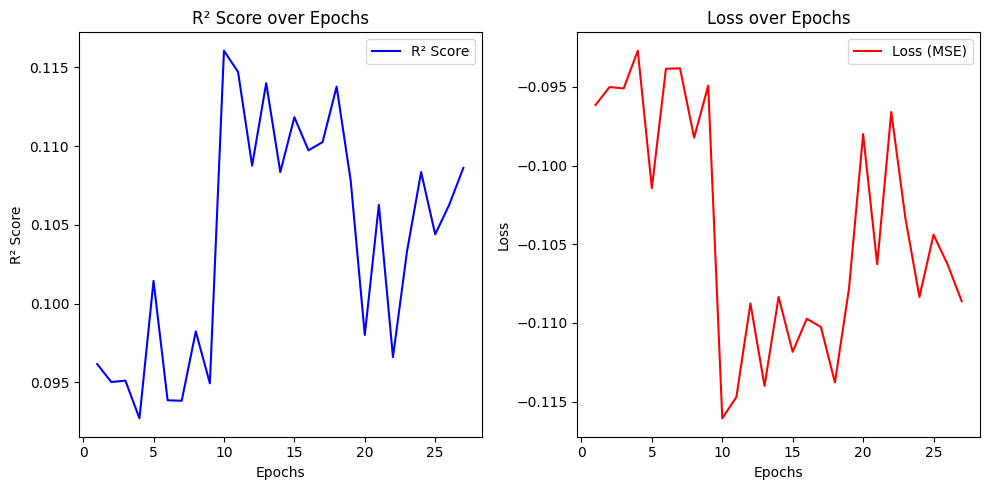

In [92]:

# Plotting R² score and loss
epochs = np.arange(1, len(grid_search.cv_results_['mean_test_score']) + 1)

plt.figure(figsize=(10, 5))

# Plot R² score
plt.subplot(1, 2, 1)
plt.plot(epochs, grid_search.cv_results_['mean_test_score'], label='R² Score', color='blue')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.title('R² Score over Epochs')
plt.legend()

# Plot Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, grid_search.cv_results_['mean_test_score'] * -1, label='Loss (MSE)', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()